<div style="color:black;font-size:60px;font-family:Brush Script MT;height:100px">
    hello

In [1]:
from operator import index
import pandas as pd
import os
from os.path import exists
import math
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from PIL import Image

In this project there are four main goals:
1. to count how many lines are in a drawing
2. to calculate the length of each line and the mean pressure when computing each line
3. to check how many hand lifts were in each drawing
4. to check if the shape is open or closed (bonus)

Glossary of Terms and introduction to data frame:
1. df_angles = the data frame that contains the angle difference between consecutive time frames computed by the dy/dx in the time frame.
2. indexes = the indexes of the rows in which a line ends in the original data frame.

In [55]:
def get_df_ready_to_work(df):
    df['X'] = df['X'].astype('float64')
    df[' Time'] = pd.to_datetime(df[' Time'])
    df[' Pressure'] = df[' Pressure'] * 100 #in order to see things more clearly in the graphs
    df['dist'] = (df['X'].diff()**2 + df[' Y'].diff()**2).apply(lambda x: math.sqrt(x)) #the distance between point to the previous one
    df.drop(df.head(1).index, inplace=True) #the first measurment dosen't have distance because it dosen't have a previous point
    df = df.reset_index()
    df.drop('index', axis=1, inplace=True)
    return df

In [56]:
def call_kid(nkid, ndraw):
    if (0 <= ndraw and ndraw <= 22):
        if os.path.isdir("C:/אריאל/שנה א/סמסטר ב/הדמיית נתונים/Data_visualization_project/Working with pandas - kids drawings project/data/"+str(nkid)):
            full_dir = "C:/אריאל/שנה א/סמסטר ב/הדמיית נתונים/Data_visualization_project/Working with pandas - kids drawings project/data/" + str(nkid) + "/SimpleTest/"
            print(full_dir+str(ndraw))
            if (exists(full_dir+str(ndraw)+".csv")):
                df = pd.read_csv(full_dir+str(ndraw)+".csv")
                df.drop(df.tail(2).index, inplace=True) #last two lines appers only on the 'X' column and contains summary of drawing time

                if (df.shape[0] < 2): #less than 2 rows means that the file is empty
                    print("For kid No' ", nkid, ", This file is empty")

                df = get_df_ready_to_work(df)
                return df
    else:
        print("One of the inputs is wrong, please try again")

discription of a 'normal' data frame of a shape:

#### 1. counting how many lines are in a drawing

The function 'dist' below gets the x and y coordinates of two points and calculates the distance between them.

In [3]:
def dist(x1, y1, x2, y2):
    return math.sqrt(pow(x1-x2,2) + pow(y1-y2,2))

The function 'drop_close_values' gets a list and out of a sequence in which every one of the elements is in difference of 10 from its prior, leaves only the first one (in each sequence, leaves the first one). Then, the function returns the list without any number sequences.

In [4]:
def drop_close_values(lst): 
    indexes_to_drop = []
    for i in range(len(lst)-1):
        if (lst[i+1]<lst[i]+9):
            indexes_to_drop.append(lst[i+1])
    new_list = [index for index in lst if index not in indexes_to_drop]
    return new_list

the function 'len_from_point_to_point' gets a data frame and two indexes, then returns the length of the line that sapreads between the points of the two indexes.

In [5]:
def len_from_point_to_point(df, a, b): #function that checks the length of a line between two points
    return df[(df.index > a) & (df.index <= b)]['dist'].sum()

the function 'average_angle_of_line' gets df_angles and two indexes, then returns the mean of the angles of the line that spreads between the points of the two indexes.

In [6]:
def average_angle_of_line(df_angles, index1, index2):
    return df_angles[(df_angles.index > index1) & (df_angles.index <= index2)]['ANG'].mean()

the function 'find_mergable_lines' is called from the function 'avoid_little_unwanted_lines'.

When searcing for lines we often gets lines that are very small and are probably a mistake of the first attempt to recognize the lines in the 'find_lines_by_angle_and_dist' function.

The function 'avoid_little_unwanted_lines' tries to reduce the amount of those 'mistake' lines and does that by picking those little lines, calculating the average angle of the line and checking if this average angle is about the same angle as the previous or the next line (and if it is, it means that we had a jump in the angle when starting the little line, but it was a deviation in the kids' drawing and not a beginning of a new line).

'find_mergable_lines' gets as parameters: df_angles,

indexes_to_drop = the list of indexes we need to drop from the 'indexes' list we have found so far,

index = the index that the line we're checking starts with,

prev = the index that the line before the line we're checking starts with,

nex = the index that the line we're checking ends with and the line after the line we're checking starts with,

nextnex = the index that the line after the line we're checking ends with,

n = the maximal angle change between to consecutive lines that we still consider the two lines as one,

need_to_go_again = parameter for the 'avoid_little_unwanted_lines' function, to let it know we're about to change the 'indexes' list, which means the number of the lines and length of each line is about to change and we need to run the loop in the 'avoid_little_unwanted_lines' function again,

change_p = a parameter that is passed and indicates that we're inside the for loop in the 'avoid_little_unwanted_lines' function,

need_to_go_again_p = a parameter that is passed and indicates that we're out of the for loop in the 'avoid_little_unwanted_lines' function.

the function finds the average angle of the current line, it's previous' and nexts', checks if the angle between the is smaller than n and adds the end/ start of the line that we want to merge to the other one to the 'indexes_to_drop' list. It returns the updated 'indexes_to_drop' list and the value of the 'need_to_go_again' parameter (True or False).

In [7]:
def find_mergable_lines(df_angles, indexes_to_drop, index, prev, nex, nextnex, n, need_to_go_again, change_p, need_to_go_again_p):
    change = False
    little_line_ang = average_angle_of_line(df_angles, index, nex) #the average angle of the current line
    next_line_ang = average_angle_of_line(df_angles, nex, nextnex)  #the average angle of the next line
    previous_line_ang = average_angle_of_line(df_angles, prev, index)  #the average angle of the previous line
    
    if(abs(little_line_ang-previous_line_ang)<=n):
        indexes_to_drop.append(index) #we want to merge the current line to its' previous
        previous_line_ang = average_angle_of_line(df_angles, prev, nex) #the angle of the new-merged line
        change = True
        need_to_go_again = True
        
    elif(abs(little_line_ang-next_line_ang)<=n):
        indexes_to_drop.append(nex) #we want to merge the current line to its' next
        next_line_ang = average_angle_of_line(df_angles, index, nextnex) #the angle of the new-merged line
        change = True
        need_to_go_again = True
        
        
    if (change_p == True): #if we're inside the for loop 
        if(abs(previous_line_ang-next_line_ang)<=n and (change == True)): #and we've done a change in this run of the loop
            indexes_to_drop.append(index)
            indexes_to_drop.append(nex)

    elif (need_to_go_again_p == True): #if we're out the for loop 
        if(abs(previous_line_ang-next_line_ang)<=n and (need_to_go_again == True)): #and we've done a change in this run of the bigger - while loop
            indexes_to_drop.append(index)
            indexes_to_drop.append(nex)
        
    return need_to_go_again, indexes_to_drop

As explained earlier, the 'avoid_little_unwanted_lines' finds the little lines we want to merge into bigger ones, merges them and terurns the updated list of 'indexes'.

In [20]:
def avoid_little_unwanted_lines(df, df_angles, indexes):
    indexes_to_drop = []
    change = False
    need_to_go_again = True
    n = 10 #the difference size of the angle that two consecutive lines has still counts as one
    x = 100.0 #the size of a line that counts as 'little' line
    
    while (need_to_go_again == True): #while we made a change in the lines during the previous run of the loop
        indexes_to_drop = []
        need_to_go_again = False
        if (len(indexes)>3):
            for index in range(1, len(indexes)-2):
                line = len_from_point_to_point(df, indexes[index], indexes[index+1]) #length of line that starts in index
                if (line < x):
                    need_to_go_again, indexes_to_drop = find_mergable_lines(df_angles, indexes_to_drop, indexes[index], indexes[index-1], indexes[index+1],
                                        indexes[index+2], n, need_to_go_again, True, False)
                
        if (len(indexes)>0):
            if(len_from_point_to_point(df, 0, indexes[0]) < x): #same check as in the 'find_mergable_lines' but for the extreme
                #case in which the line dosen't have previous
                little_line_ang = average_angle_of_line(df_angles, 0, indexes[0])
                next_line_ang = average_angle_of_line(df_angles, indexes[0], indexes[1])
                if(abs(little_line_ang-next_line_ang)<=n):
                        indexes_to_drop.append(indexes[0])
                        need_to_go_again = True

        if (len(indexes)>1):
            if(len_from_point_to_point(df, indexes[0], indexes[1]) < x):
                need_to_go_again, indexes_to_drop = find_mergable_lines(df_angles, indexes_to_drop, indexes[0], 0, indexes[1],
                                        indexes[2], n, need_to_go_again, False, True)

        if (len(indexes)>2):
            if(len_from_point_to_point(df, indexes[len(indexes)-2], indexes[len(indexes)-1]) < x):
                need_to_go_again, indexes_to_drop = find_mergable_lines(df_angles, indexes_to_drop, indexes[len(indexes)-2], indexes[len(indexes)-3],indexes[len(indexes)-1],
                                                                        len(df_angles)-1, n, need_to_go_again, False, True)

        if (len(indexes)>1):        
            if(len_from_point_to_point(df, indexes[len(indexes)-1], len(df)-1) < x):#same check as in the 'find_mergable_lines' but for the extreme case in which the
                #line dosen't have next
                little_line_ang = average_angle_of_line(df_angles, indexes[len(indexes)-1], len(df_angles)-1)
                previous_line_ang = average_angle_of_line(df_angles, indexes[len(indexes)-2], indexes[len(indexes)-1])
                if(abs(little_line_ang-previous_line_ang)<= n):
                        indexes_to_drop.append(len(indexes)-1)
                        need_to_go_again = True
        indexes_to_drop = set(indexes_to_drop)
        indexes = [index for index in indexes if index not in indexes_to_drop]

    indexes_to_drop = set(indexes_to_drop)
    indexes = [index for index in indexes if index not in indexes_to_drop]
    
    return indexes

The 'find_lines_by_angle_and_dist' gets as parameters a data frame os a shape and a boolean 'to_print'. it returns the list 'indexes' (see entry 2 in the glossary of terms), and by the value of 'to_print' it prints\ dosen't print the number of line in the shape.

In [23]:
def find_lines_by_angle_and_dist(df, to_print):
    indexes = []
    lst = []
    df1 = pd.DataFrame({'Y_DIF': df[' Y'].diff()})
    df2 = pd.DataFrame({'X_DIF': df['X'].diff()})
    
    df_change = pd.concat([df1, df2, df[' Time'], df[' Pressure']], axis=1)
    df_change.drop(df_change.head(1).index, inplace=True) #the values in df1, df2 in the first row are always NaN
    df_change = df_change[df_change['X_DIF'] != 0] #due to the fact we're going to calculate dy/dx, dx needs to be defined (not 0)
    df_angles = pd.DataFrame({'ANG': (df_change['Y_DIF']/df_change['X_DIF']).apply(lambda x: math.degrees(math.atan(x))), 
                             ' Time': df_change[' Time'], ' Pressure': df_change[' Pressure']})
    df_angles['diff'] = df_angles['ANG'].diff()
    df_angles.drop(df_angles.head(1).index, inplace=True) #first row is NaN at column 'diff'
    df_angles['idx'] = df_angles.index
    df_angles['ave_ang'] = df_angles['idx'].apply(lambda x: df_angles['ANG'][(df_angles.index > x) & (df_angles.index <= x+5)].mean())
    df_angles.drop(df_angles.tail(1).index, inplace=True) #last line doedn't have average of next angles
    df_angles.drop(['idx'], axis=1, inplace=True)
    df_angles = df_angles.reset_index() #indexes at df_angles are not consecutive
    
    for point in df_angles.index:
        if ((df_angles.loc[point, 'diff'] > 30 and df_angles.loc[point, 'diff'] < 160) or 
            (df_angles.loc[point, 'diff'] < -30 and df_angles.loc[point, 'diff'] > -160)): #change of angles that implies on start of a new line
            if (point -1 < 0):
                continue
            if (abs(df_angles.loc[point-1, 'ANG'] - df_angles.loc[point, 'ave_ang']) > 30 and
               abs(df_angles.loc[point-1, 'ANG'] - df_angles.loc[point, 'ave_ang']) < 160):
                indexes.append(df_angles.loc[point, 'index'])
    
    if (df['dist'].std()>2*df['dist'].median()): #change in distance between two consecutive time points that implies on start of a new line
        lst = df[df['dist'] > (df['dist'].median()+(df['dist'].std()/2))].index.values.tolist()
    
    
    indexes = sorted(indexes + lst)
    indexes = drop_close_values(indexes)
    
    
    indexes_to_drop = []
    flag = True
    
    while(flag == True): #droping lines that are too short to be intentional
        if (len(indexes)==0):
            break
        indexes_to_drop = []
        flag = False
        if (len_from_point_to_point(df, 0, indexes[0]) <= 16.0):
            indexes_to_drop.append(indexes[0])
            flag = True
        if (len_from_point_to_point(df, indexes[len(indexes)-1], len(df)-1) <= 16.0):
            indexes_to_drop.append(indexes[len(indexes)-1])
            flag = True
        for i in range(1, len(indexes)):
            if (len_from_point_to_point(df, indexes[i-1], indexes[i]) <= 16.0):
                indexes_to_drop.append(indexes[i])
                flag = True
        indexes = [index for index in indexes if index not in indexes_to_drop]
    
    
    df_angles = df_angles.set_index('index')
    if (len(indexes)!=0):
        indexes = avoid_little_unwanted_lines(df, df_angles, indexes)

    
    num_of_lines = len(indexes) + 1 # +1 is adding the end of the last line that is not in the 'indexes' list
    
    if (to_print==True):
        print("Number of lines in shape is: ", num_of_lines)
    
    return list(indexes)

Let's see an example:

(notice that there are red dots where a line begins/ends)

C:/אריאל/שנה א/סמסטר ב/הדמיית נתונים/Data_visualization_project/Working with pandas - kids drawings project/data/7558/SimpleTest/3
Number of lines in shape is:  1


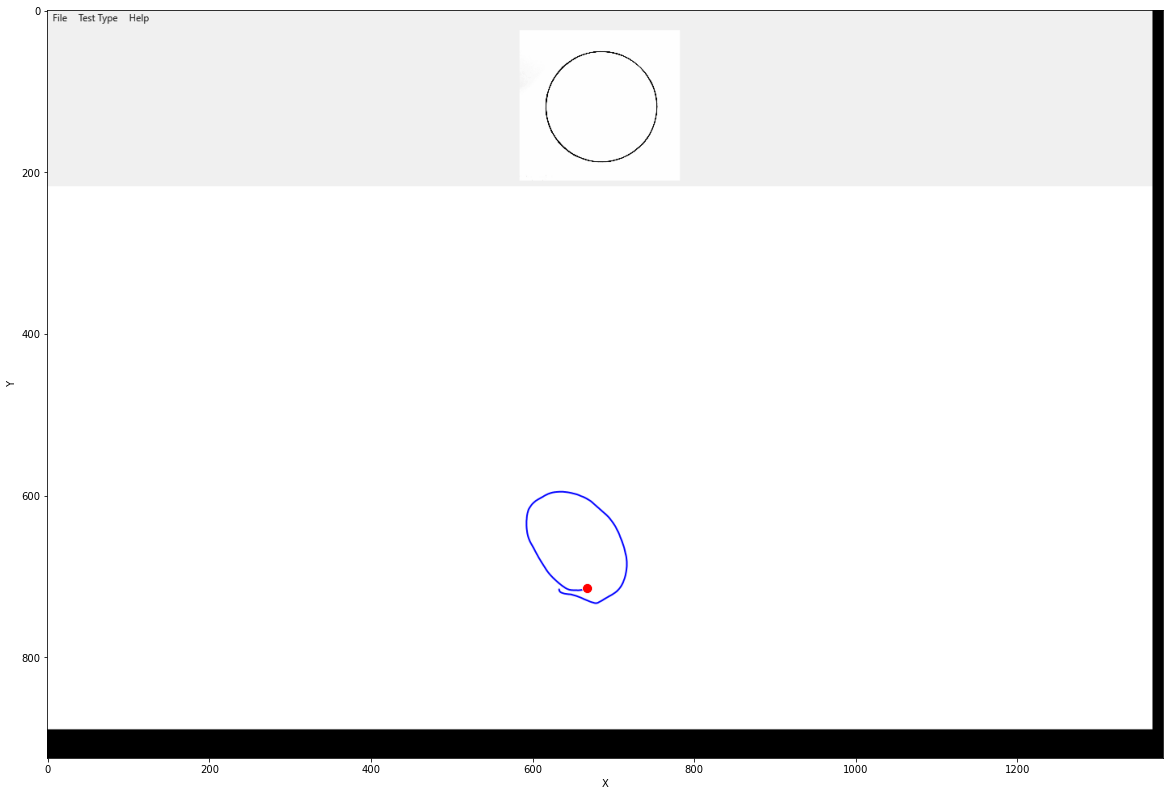

In [63]:
full_dir = "C:/אריאל/שנה א/סמסטר ב/הדמיית נתונים/Data_visualization_project/Working with pandas - kids drawings project/data/" + str(7558) + "/SimpleTest/"
df = call_kid(7558,3)

indexes = find_lines_by_angle_and_dist(df, True)
lst = [index for index in df.index if index in indexes]
lst.append(0)
dfplot = df.iloc[lst]
sns.scatterplot(data=dfplot, x='X', y=' Y', s=100, c=['#ff0000'])
image = Image.open(full_dir+str(3)+".PNG")
pyplot.imshow(image)
plt.show()

And another one:

C:/אריאל/שנה א/סמסטר ב/הדמיית נתונים/Data_visualization_project/Working with pandas - kids drawings project/data/7554/SimpleTest/12
Number of lines in shape is:  4


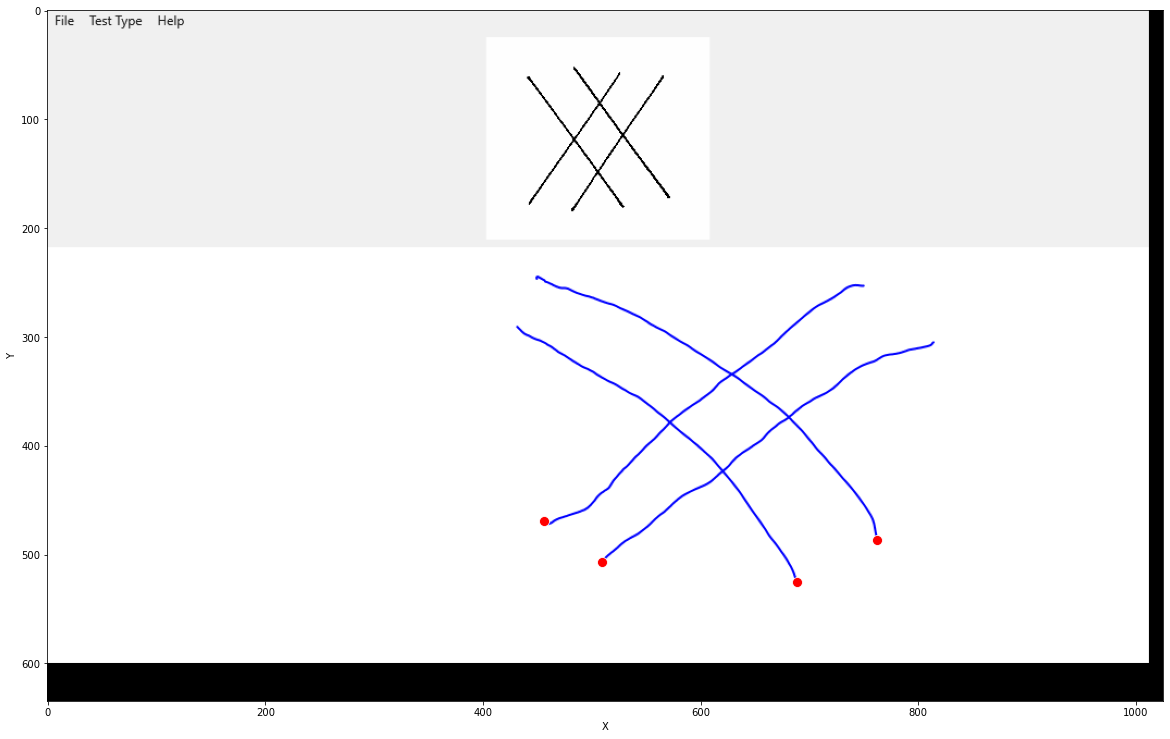

In [71]:
full_dir = "C:/אריאל/שנה א/סמסטר ב/הדמיית נתונים/Data_visualization_project/Working with pandas - kids drawings project/data/" + str(7554) + "/SimpleTest/"
df = call_kid(7554,12)

indexes = find_lines_by_angle_and_dist(df, True)
lst = [index for index in df.index if index in indexes]
lst.append(0)
dfplot = df.iloc[lst]
sns.scatterplot(data=dfplot, x='X', y=' Y', s=100, c=['#ff0000'])
image = Image.open(full_dir+str(12)+".PNG")
pyplot.imshow(image)
plt.show()

Last, let's see an example where the model is wrong, and try to anlaize it:

C:/אריאל/שנה א/סמסטר ב/הדמיית נתונים/Data_visualization_project/Working with pandas - kids drawings project/data/7563/SimpleTest/8
Number of lines in shape is:  3


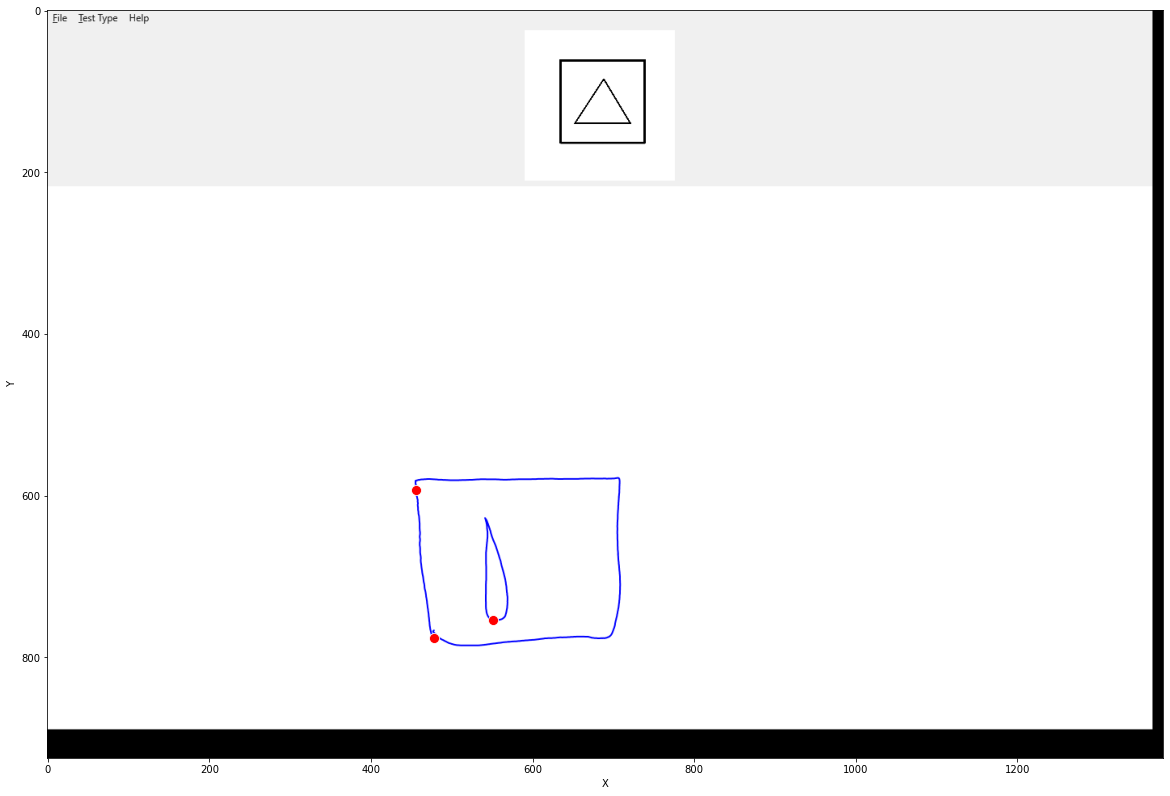

In [72]:
full_dir = "C:/אריאל/שנה א/סמסטר ב/הדמיית נתונים/Data_visualization_project/Working with pandas - kids drawings project/data/" + str(7563) + "/SimpleTest/"
df = call_kid(7563,8)

indexes = find_lines_by_angle_and_dist(df, True)
lst = [index for index in df.index if index in indexes]
lst.append(0)
dfplot = df.iloc[lst]
sns.scatterplot(data=dfplot, x='X', y=' Y', s=100, c=['#ff0000'])
image = Image.open(full_dir+str(8)+".PNG")
pyplot.imshow(image)
plt.show()

Due to the fact that the kid drew the two right corners of the rectangle a bit rounded, the model recognized all three lines as one. Moreover, the kid drew the the triangle rounded as well, which we can only guess that the model recognized as circle hence found only one line.

#### 2. calculating the length of each line and the mean pressure when computing each line:

The 'find_lines_length_by_index' and the 'find_lines_pressure_by_index' functions finds the length of each line of the shape and the average pressure that is activated when drawing each line, respectively.  

In [10]:
def find_lines_length_by_index(df, indexes):
    if (len(indexes)==0):
        print("Total length: ", df['dist'].sum())
        return
        
    elif (len(indexes)==1):
        print("Length of line 1: ", df[df.index <= indexes[0]]['dist'].sum())
        print("Length of line 2: ", df[df.index > indexes[0]]['dist'].sum())
        return
        
    for i in range(len(indexes)):
        if (i==0):
            print("Length of line 1: ", df[df.index <= indexes[0]]['dist'].sum())
        elif (i==len(indexes)-1):
            print("Length of line ", (i+1), ": ", df[(df.index > indexes[i-1]) & (df.index <= indexes[i])]['dist'].sum())
            print("Length of line ", len(indexes) + 1,": ", df[df.index > indexes[len(indexes)-1]]['dist'].sum())
        else:
            print("Length of line ", (i+1), ": ", df[(df.index > indexes[i-1]) & (df.index <= indexes[i])]['dist'].sum())

In [11]:
def find_lines_pressure_by_index(df, indexes):
    if (len(indexes)==0):
        print("Average pressure: ", df[' Pressure'].mean())
        return
    
    elif (len(indexes)==1):
        print("Average pressure of line 1: ", df[df.index <= indexes[0]][' Pressure'].mean())
        print("Average pressure of line 2: ", df[df.index > indexes[0]][' Pressure'].mean())
        return
        
    for i in range(len(indexes)):
        if (i==0):
            print("Average pressure of line 1: ", df[df.index <= indexes[0]][' Pressure'].mean())
        elif (i==len(indexes)-1):
            print("Average pressure of line ", (i+1), ": ", df[(df.index > indexes[i-1]) & (df.index <= indexes[i])][' Pressure'].mean())
            print("Average pressure of line ", len(indexes) + 1,": ", df[df.index > indexes[len(indexes)-1]][' Pressure'].mean())
        else:
            print("Average pressure of line ", (i+1), ": ", df[(df.index > indexes[i-1]) & (df.index <= indexes[i])][' Pressure'].mean())

Let's see an example:

C:/אריאל/שנה א/סמסטר ב/הדמיית נתונים/Data_visualization_project/Working with pandas - kids drawings project/data/7572/SimpleTest/9
Number of lines in shape is:  6
Length of line 1:  196.2726078910526
Length of line  2 :  403.6735118928976
Length of line  3 :  564.2391423365268
Length of line  4 :  105.08562944654749
Length of line  5 :  825.3321686998875
Length of line  6 :  430.4934679517998
Average pressure of line 1:  54.20394405241935
Average pressure of line  2 :  60.1050400152439
Average pressure of line  3 :  76.82281494140625
Average pressure of line  4 :  32.15196397569444
Average pressure of line  5 :  67.57953350360577
Average pressure of line  6 :  67.57527669270833


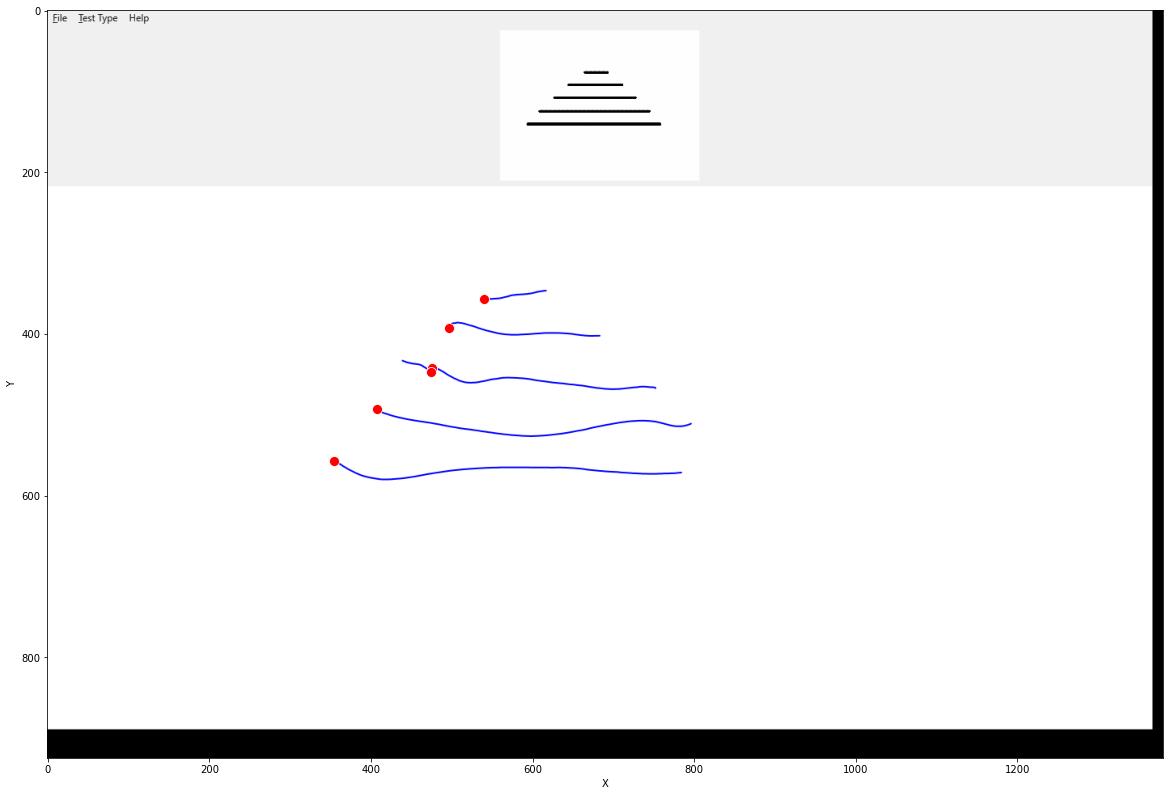

In [79]:
full_dir = "C:/אריאל/שנה א/סמסטר ב/הדמיית נתונים/Data_visualization_project/Working with pandas - kids drawings project/data/" + str(7572) + "/SimpleTest/"
df = call_kid(7572,9)

indexes = find_lines_by_angle_and_dist(df, True)
find_lines_length_by_index(df, indexes)
find_lines_pressure_by_index(df, indexes)

lst = [index for index in df.index if index in indexes]
lst.append(0)
dfplot = df.iloc[lst]
sns.scatterplot(data=dfplot, x='X', y=' Y', s=100, c=['#ff0000'])
image = Image.open(full_dir+str(9)+".PNG")
pyplot.imshow(image)
plt.show()

#### 3. checking how many hand lifts were in each drawing

In [12]:
def find_hand_off_by_pressure(df):
    ave_pressure = df[' Pressure'].mean()
    min_pressure = df[' Pressure'].min()
    max_pressure = df[' Pressure'].max()
    smallest_values = df[df[' Pressure'] < (min_pressure + max_pressure)/2].sort_index()
    smallest_values['idx'] = smallest_values.index
    smallest_values['idx_shift'] = smallest_values.shift()['idx']
    smallest_values.drop(smallest_values.head(1).index,inplace=True)
    num_of_hand_lifts = (smallest_values['idx']-smallest_values['idx_shift']).apply(lambda x: 0 if x==1.0 else 1).sum() + 1
    print("The number of hand lifts computed by pressure is: ", num_of_hand_lifts)

#### 4. checking if the shape is open or closed

The 'find_line' function gets as parameters a data frame, its' 'indexes' and 'point' which is an index of a point on a line and returns the number of the line the point is on, and the start_index and the end_index of that line.

In [13]:
def find_line(df, indexes, point):
    my_line = 0
    sta_idx = 0
    end_idx = 0
    if (point <= indexes[0]):
        my_line = 0
        sta_idx = 0
        end_idx = indexes[0]
    elif (point > indexes[len(indexes)-1]):
        my_line = len(indexes) + 1
        sta_idx = indexes[len(indexes)-1]
        end_idx = len(df)
    else:
        for line in range(1, len(indexes)):
            if (point > indexes[line-1] and point <= indexes[line]):
                my_line = line + 1
                sta_idx = indexes[line-1]
                end_idx = indexes[line]
    return my_line, sta_idx, end_idx   

The 'which_lines_are_meetings' gets a data frame and its' 'indexes' list and returns a truth value - if there are cutting points between lines and a data frame of the lines and the cutting lines, if exists. 

In [14]:
def which_lines_are_meetings(df, indexes):
    ave_radius = 0
    meet_list = []
    my_line = 0
    skipin = 0 #in order to avoid diagnosing two consecutive points as intersecting we made 2 variables one for each loop,
    skipout = 0 #that functions as a flag - not to check intersect with the next 'skipin'/'skipout' (value) points.
    if (len(indexes)==0):
        ave_radius = df['dist'].mean()
        for point in df.index:
            if (skipout > 0):
                skipout = skipout - 1
                continue
            for point2 in df.index:
                if (skipin > 0):
                    skipin = skipin - 1
                    continue
                elif ((point2>=point-10) and (point2<=point+10)): #if it's in the range of close points
                    continue
                elif (dist(df.loc[point, 'X'], df.loc[point, ' Y'], df.loc[point2, 'X'], df.loc[point2, ' Y'])
                      < (ave_radius + df['dist'].std())):
                    meet_list.append([1, 1, min(point, point2), max(point, point2)])
                    skipin = 3
                    skipout = 3
                else:
                    continue
                    
    else:
        for point in df.index:
            if (skipout > 0):
                skipout = skipout - 1
                continue
            my_line, start_line, end_line = find_line(df, indexes, point)
            ave_radius = df[(df.index > start_line) & (df.index <= end_line)]['dist'].mean()
            for point2 in df.index:
                if (skipin > 0):
                    skipin = skipin - 1
                    continue
                elif ((point2>=point-10) and (point2<=point+10)):
                    continue
                elif (dist(df.loc[point, 'X'], df.loc[point, ' Y'], df.loc[point2, 'X'], df.loc[point2, ' Y']) 
                      < (ave_radius + df['dist'].std())):
                    point2_line, start2, end2 = find_line(df, indexes, point2)
                    meet_list.append([min(my_line, point2_line), max(my_line, point2_line),
                                      min(point, point2), max(point, point2)])
                    skipin = 3
                    skipout = 3
                else:
                    continue
                    
    if (len(meet_list) == 0):
        return (False, [])
    
    return (True, pd.DataFrame(meet_list).sort_values(by=[2]))

The 'make_intersections' function calls to the 'which_lines_are_meetings' function and returns a data frame containing the data frame that have returned from the 'which_lines_are_meetings' function, such that each intersection appears only once. 

If the 'which_lines_are_meetings' function returns 'False', the 'make_intersection' function returns 'False' as well.

In [15]:
def make_intersections(df, indexes):
    b, data_frame = which_lines_are_meetings(df, indexes)
    if b:
        rows_to_drop = []
        data_frame = data_frame.reset_index()
        data_frame.drop('index', axis=1, inplace=True)
        
        for i in range(0, len(data_frame)-1):
            if (data_frame.loc[i+1, 2] < data_frame.loc[i, 2] + 10):
                rows_to_drop.append(i+1)
        
        data_frame.drop(rows_to_drop, inplace=True)
        data_frame = data_frame.reset_index()
        data_frame.drop('index', axis=1, inplace=True)
        return (True, data_frame.loc[0: , :1])
    
    else:
        return (False, [])

The 'find_circle_recursive' is called from the 'is_shape_closed' function in order to answer the question if the shape is closed.

The function gets a data frame of intersections, start = line number we start from, idx_check = a value we need to find on the left column of the data frame, lst = list of the route the function have done so far.

The function tries recursively to find a circle that starts at the start it has been given. If it finds another circle on the way - it return True (the circle we're looking for contains a circle and thus the shape is closed).

In [16]:
def find_circle_recursive(data_frame, start, idx_check, lst):
    for i in range(len(data_frame)):
        if (data_frame.loc[i, 1] == start):
            return True
        if ((i==len(data_frame)-1) & (data_frame.loc[i, 0]!=idx_check)):
            return False
        if (data_frame.loc[i, 0] == idx_check):
            if (len(lst)!=0):
                for edge in lst:
                    if (edge == idx_check):
                        return True
            b = find_circle_recursive(data_frame, start, data_frame.loc[i, 1], lst.append(idx_check))
            if b:
                return b
            lst.remove(idx_check)
    return False

The 'is_shape_close' function uses all the functions above to determine if a shape is close or open. It returns a truth value.

In [17]:
def is_shape_closed(df, indexes):
    boolian = False
    b, data_frame = make_intersections(df, indexes)
    if b:
        for row in data_frame.index:
            if (data_frame.loc[row, 0] == data_frame.loc[row, 1]):
                boolian = True

        for row in data_frame.index:
            for row2 in data_frame.index:
                if (row == row2):
                    continue
                if ((data_frame.loc[row, 0] == data_frame.loc[row2, 0]) and (data_frame.loc[row, 1] == data_frame.loc[row2, 1])):
                    boolian = True
    
        if (boolian == False):
             for i in data_frame.index:
                    boolian = find_circle_recursive(data_frame, data_frame.loc[i, 0], data_frame.loc[i, 1], [])
    
        return boolian
    
    else:
        return False

Let's see some examples!

C:/אריאל/שנה א/סמסטר ב/הדמיית נתונים/Data_visualization_project/Working with pandas - kids drawings project/data/7569/SimpleTest/19
Number of lines in shape is:  2
Is the shape contains a closed sub-shape?  True


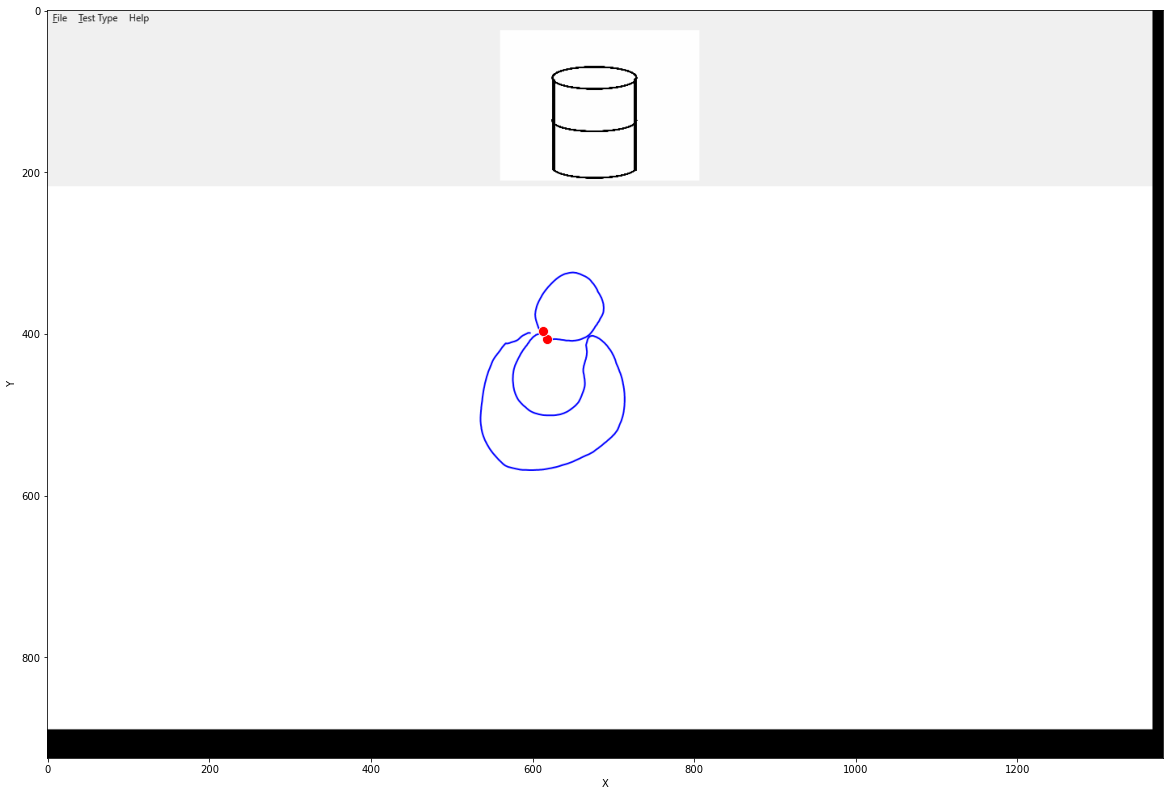

In [85]:
full_dir = "C:/אריאל/שנה א/סמסטר ב/הדמיית נתונים/Data_visualization_project/Working with pandas - kids drawings project/data/" + str(7569) + "/SimpleTest/"
df = call_kid(7569,19)

indexes = find_lines_by_angle_and_dist(df, True)
print("Is the shape contains a closed sub-shape? ", is_shape_closed(df, indexes))

lst = [index for index in df.index if index in indexes]
lst.append(0)
dfplot = df.iloc[lst]
sns.scatterplot(data=dfplot, x='X', y=' Y', s=100, c=['#ff0000'])
image = Image.open(full_dir+str(19)+".PNG")
pyplot.imshow(image)
plt.show()

C:/אריאל/שנה א/סמסטר ב/הדמיית נתונים/Data_visualization_project/Working with pandas - kids drawings project/data/7574/SimpleTest/11
Number of lines in shape is:  9
Is the shape contains a closed sub-shape?  True


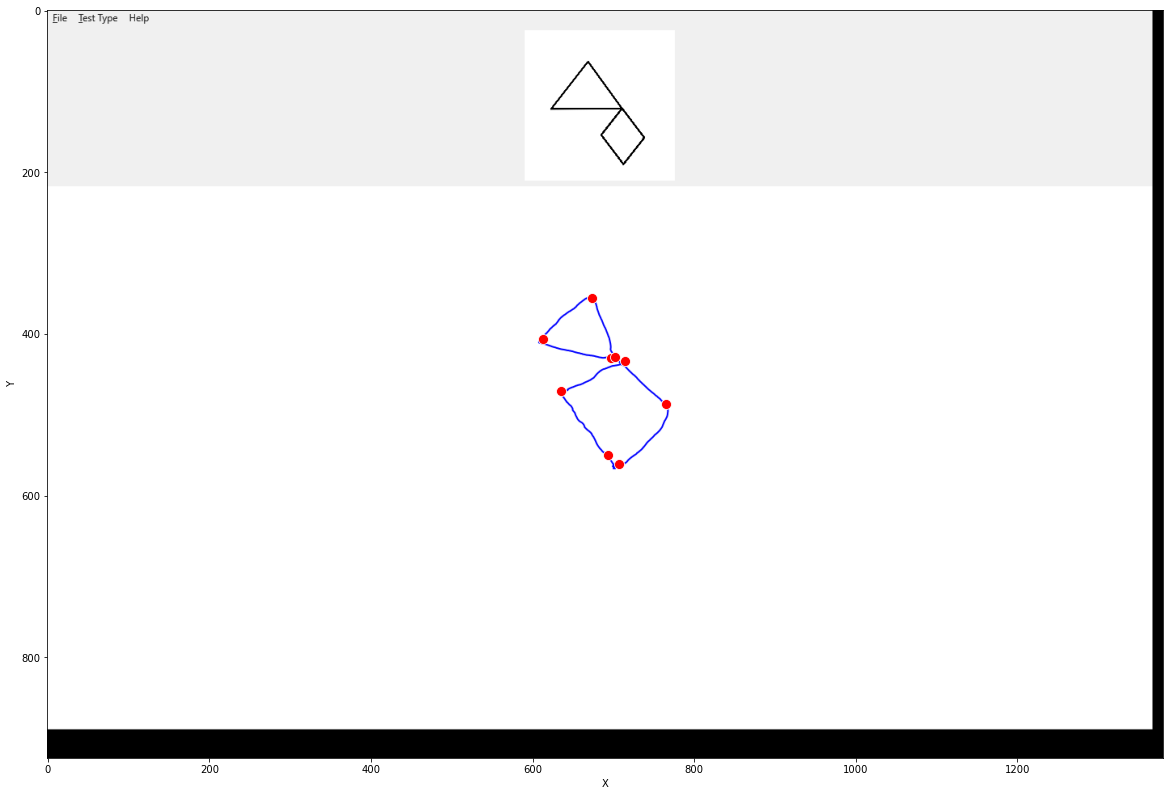

In [95]:
full_dir = "C:/אריאל/שנה א/סמסטר ב/הדמיית נתונים/Data_visualization_project/Working with pandas - kids drawings project/data/" + str(7574) + "/SimpleTest/"
df = call_kid(7574,11)

indexes = find_lines_by_angle_and_dist(df, True)
print("Is the shape contains a closed sub-shape? ", is_shape_closed(df, indexes))

lst = [index for index in df.index if index in indexes]
lst.append(0)
dfplot = df.iloc[lst]
sns.scatterplot(data=dfplot, x='X', y=' Y', s=100, c=['#ff0000'])
image = Image.open(full_dir+str(11)+".PNG")
pyplot.imshow(image)
plt.show()

C:/אריאל/שנה א/סמסטר ב/הדמיית נתונים/Data_visualization_project/Working with pandas - kids drawings project/data/7557/SimpleTest/1
Number of lines in shape is:  1
Is the shape contains a closed sub-shape?  False


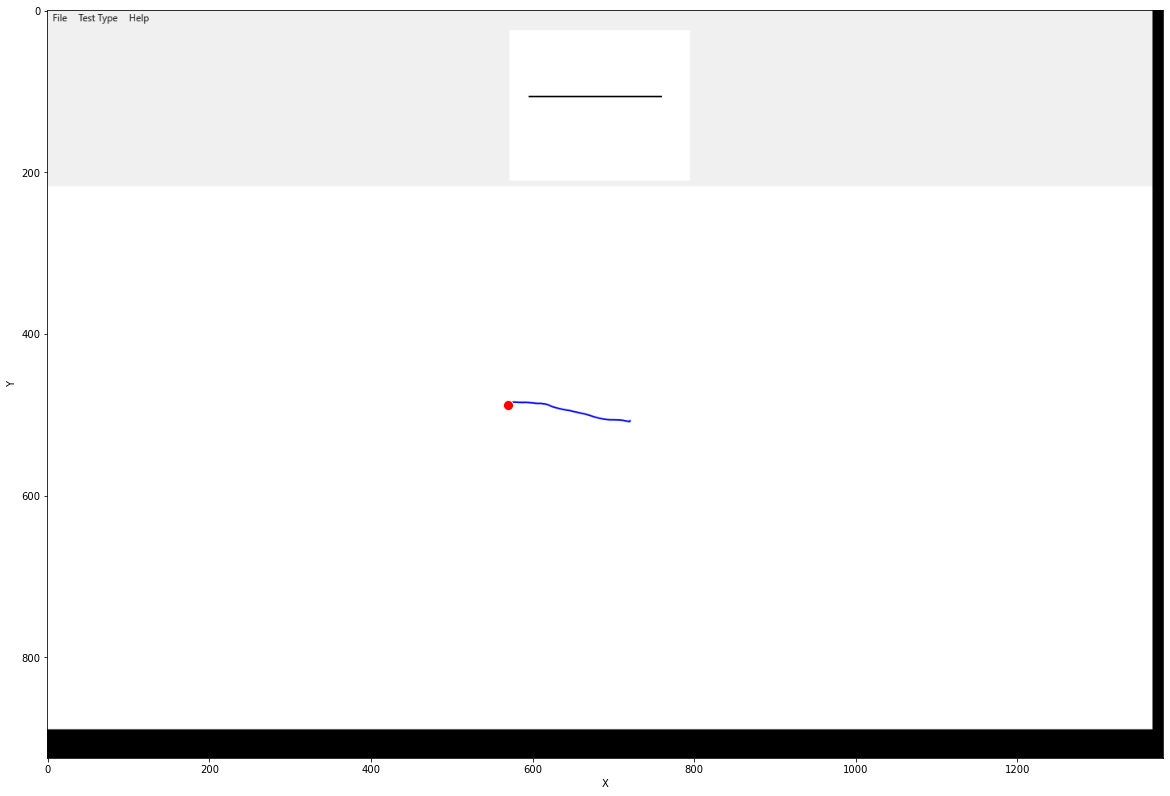

In [105]:
full_dir = "C:/אריאל/שנה א/סמסטר ב/הדמיית נתונים/Data_visualization_project/Working with pandas - kids drawings project/data/" + str(7557) + "/SimpleTest/"
df = call_kid(7557,1)

indexes = find_lines_by_angle_and_dist(df, True)
print("Is the shape contains a closed sub-shape? ", is_shape_closed(df, indexes))

lst = [index for index in df.index if index in indexes]
lst.append(0)
dfplot = df.iloc[lst]
sns.scatterplot(data=dfplot, x='X', y=' Y', s=100, c=['#ff0000'])
image = Image.open(full_dir+str(1)+".PNG")
pyplot.imshow(image)
plt.show()

testing functions:

In [51]:
def check_kid_draw(nkid, ndraw):
    if (0 <= ndraw and ndraw <= 22):
        if os.path.isdir("C:/אריאל/שנה א/סמסטר ב/הדמיית נתונים/Data_visualization_project/Working with pandas - kids drawings project/data/"+str(nkid)):
            full_dir = "C:/אריאל/שנה א/סמסטר ב/הדמיית נתונים/Data_visualization_project/Working with pandas - kids drawings project/data/" + str(nkid) + "/SimpleTest/"
            print(full_dir+str(ndraw))
            if (exists(full_dir+str(ndraw)+".csv")):
                plt.figure(figsize=(20, 20))
                image = Image.open(full_dir+str(ndraw)+".PNG")
                pyplot.imshow(image)
                #display()
                df = pd.read_csv(full_dir+str(ndraw)+".csv")
                df.drop(df.tail(2).index, inplace=True) #last two lines appers only on the 'X' column and contains summary of drawing time

                if (df.shape[0] < 2): #less than 2 rows means that the file is empty
                    print("For kid No' ", nkid, ", This file is empty")

                df = get_df_ready_to_work(df)

                indexes = find_lines_by_angle_and_dist(df, True)
                find_lines_length_by_index(df, indexes)
                find_lines_pressure_by_index(df, indexes)
                find_hand_off_by_pressure(df)
                print("Is the shape contains a closed sub-shape? ", is_shape_closed(df, indexes))
                
                lst = [index for index in df.index if index in indexes]
                lst.append(0)
                dfplot = df.iloc[lst]
                sns.scatterplot(data=dfplot, x='X', y=' Y', s=100, c=['#ff0000'])
    else:
        print("One of the inputs is wrong, please try again")

        

C:/אריאל/שנה א/סמסטר ב/הדמיית נתונים/Data_visualization_project/Working with pandas - kids drawings project/data/7571/SimpleTest/3
Number of lines in shape is:  6
Length of line 1:  49.660587810926486
Length of line  2 :  97.09824474318542
Length of line  3 :  33.5908432025113
Length of line  4 :  423.33284853198523
Length of line  5 :  245.99156400339547
Length of line  6 :  44.39599942605533
Average pressure of line 1:  53.828125
Average pressure of line  2 :  71.27793255974265
Average pressure of line  3 :  70.47183388157895
Average pressure of line  4 :  76.39238911290323
Average pressure of line  5 :  90.771484375
Average pressure of line  6 :  97.15431342690678
The number of hand lifts computed by pressure is:  3
Is the shape contains a closed sub-shape?  True


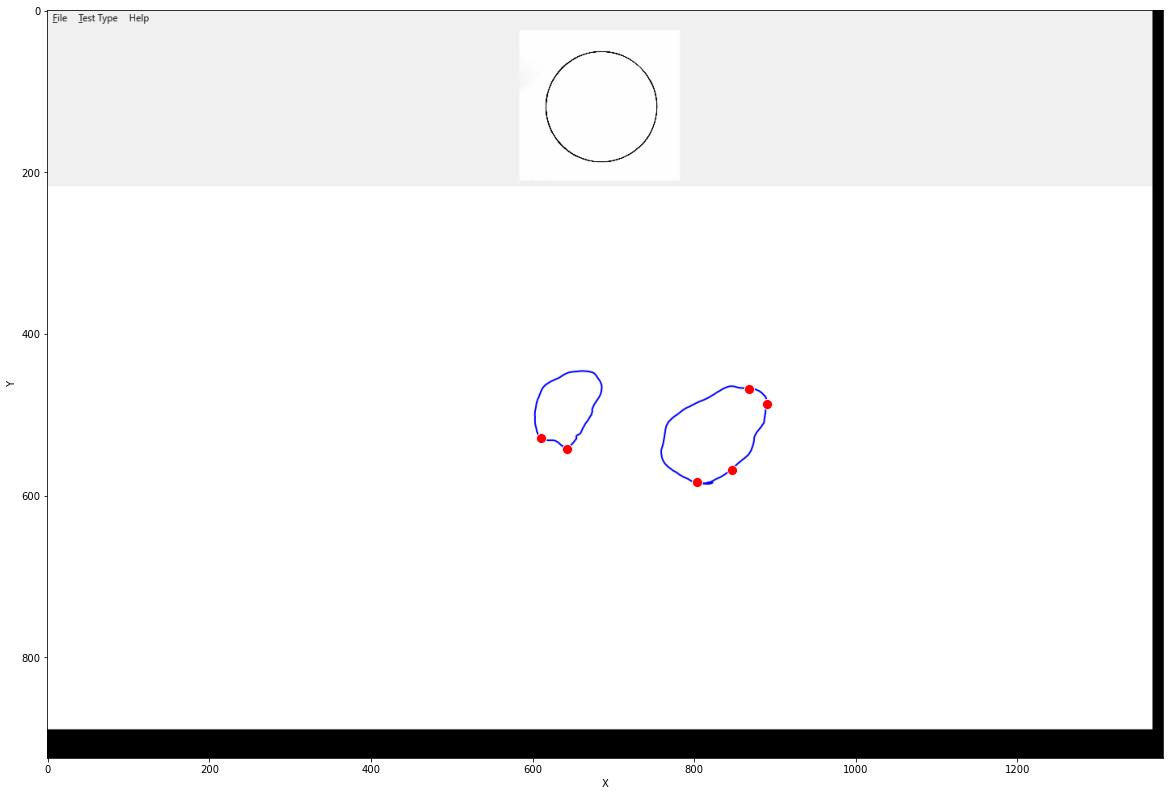

In [54]:
check_kid_draw(7571, 3)

In [ ]:
sns.lineplot(data=df,y='dist', x=' Time')
sns.lineplot(data=df,y=' Pressure', x=' Time')
plt.show() #distance-Time graph with added line for pressure